In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from gensim.models import KeyedVectors

from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Embedding,Dropout,GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import pickle

# Data Extraction

In [2]:
train_data = pd.read_csv('train_dataset_multiclass.csv',index_col=0)
print(train_data.shape,end="\n\n")
print(train_data['Issue'].value_counts())
train_data.head()

(5908, 2)

Problem with a purchase shown on your statement    1993
Incorrect information on your report               1191
Managing an account                                 935
Fees or interest                                    904
Other features, terms, or problems                  885
Name: Issue, dtype: int64


,Consumer complaint narrative,Issue
57519,The Citibank Credit Card company is a ridiculo...,Problem with a purchase shown on your statement
2790,Hi I went to a local bar on the evening of XX/...,Problem with a purchase shown on your statement
54277,I transferred XXXX ThankYou Points ( Citibank ...,"Other features, terms, or problems"
587,I was in XXXX XXXX and used my CITIBANK credit...,Problem with a purchase shown on your statement
12420,I clicked a promotion on citibank 's website t...,Managing an account


In [3]:
test_data = pd.read_csv('test_dataset_multiclass.csv',index_col=0)
print(test_data.shape,end="\n\n")
print(test_data['Issue'].value_counts())
test_data.head()

(2532, 2)

Problem with a purchase shown on your statement    854
Incorrect information on your report               510
Managing an account                                401
Fees or interest                                   388
Other features, terms, or problems                 379
Name: Issue, dtype: int64


,Consumer complaint narrative,Issue
17357,"Back in 2015, we noticed a charge on our Macy ...",Fees or interest
6524,"- On XX/XX/XXXX, I purchased 1 ticket XXXX {$3...",Problem with a purchase shown on your statement
23689,I hope all is well ... \nThe reason why Im wri...,Fees or interest
6960,Citibank had requested some XXXX documents ear...,Managing an account
7204,On XX/XX/2021 I authorized a payment of amount...,Managing an account


# Data Preprocessing

In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
TO_REMOVE_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
NEXTLINE_REPLACE = re.compile('\n')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = NEXTLINE_REPLACE.sub(' ',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = TO_REMOVE_SYMBOLS_RE.sub('', text)  
    text = text.replace('x', '')
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    return text

In [5]:
train_data['Cleaned_Reviews'] = train_data['Consumer complaint narrative'].apply(clean_text)
test_data['Cleaned_Reviews']  = test_data['Consumer complaint narrative'].apply(clean_text)

In [6]:
train_data.head()

,Consumer complaint narrative,Issue,Cleaned_Reviews
57519,The Citibank Credit Card company is a ridiculo...,Problem with a purchase shown on your statement,citibank credit card company ridiculous rude c...
2790,Hi I went to a local bar on the evening of XX/...,Problem with a purchase shown on your statement,hi went local bar evening made two separate tr...
54277,I transferred XXXX ThankYou Points ( Citibank ...,"Other features, terms, or problems",transferred thankyou points citibank book awar...
587,I was in XXXX XXXX and used my CITIBANK credit...,Problem with a purchase shown on your statement,used citibank credit card used clothing store ...
12420,I clicked a promotion on citibank 's website t...,Managing an account,clicked promotion citibank website stated put ...


In [7]:
test_data.head()

,Consumer complaint narrative,Issue,Cleaned_Reviews
17357,"Back in 2015, we noticed a charge on our Macy ...",Fees or interest,back 2015 noticed charge macy credit card call...
6524,"- On XX/XX/XXXX, I purchased 1 ticket XXXX {$3...",Problem with a purchase shown on your statement,purchased 1 ticket 39000 supposed take place p...
23689,I hope all is well ... \nThe reason why Im wri...,Fees or interest,hope well reason im writing bill couple days l...
6960,Citibank had requested some XXXX documents ear...,Managing an account,citibank requested documents earlier year prov...
7204,On XX/XX/2021 I authorized a payment of amount...,Managing an account,2021 authorized payment amount 260000 pay cred...


In [8]:
combined_data = pd.concat([train_data,test_data],axis=0)
print(combined_data.shape)
combined_data.head()

(8440, 3)


,Consumer complaint narrative,Issue,Cleaned_Reviews
57519,The Citibank Credit Card company is a ridiculo...,Problem with a purchase shown on your statement,citibank credit card company ridiculous rude c...
2790,Hi I went to a local bar on the evening of XX/...,Problem with a purchase shown on your statement,hi went local bar evening made two separate tr...
54277,I transferred XXXX ThankYou Points ( Citibank ...,"Other features, terms, or problems",transferred thankyou points citibank book awar...
587,I was in XXXX XXXX and used my CITIBANK credit...,Problem with a purchase shown on your statement,used citibank credit card used clothing store ...
12420,I clicked a promotion on citibank 's website t...,Managing an account,clicked promotion citibank website stated put ...


In [9]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(combined_data['Cleaned_Reviews'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 19320 unique tokens.


In [10]:
le = LabelEncoder()
le.fit(train_data['Issue'])

LabelEncoder()

In [11]:
train_data['Label'] = le.transform(train_data['Issue'])
test_data['Label'] = le.transform(test_data['Issue'])
test_data.head(2)

,Consumer complaint narrative,Issue,Cleaned_Reviews,Label
17357,"Back in 2015, we noticed a charge on our Macy ...",Fees or interest,back 2015 noticed charge macy credit card call...,0
6524,"- On XX/XX/XXXX, I purchased 1 ticket XXXX {$3...",Problem with a purchase shown on your statement,purchased 1 ticket 39000 supposed take place p...,4


In [12]:
X_train = tokenizer.texts_to_sequences(train_data['Cleaned_Reviews'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

y_train = to_categorical(train_data['Label'])
y_train.shape

Shape of data tensor: (5908, 200)


(5908, 5)

In [13]:
X_test = tokenizer.texts_to_sequences(test_data['Cleaned_Reviews'].values)
X_test = pad_sequences(X_test,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

y_test = to_categorical(test_data['Label'])
y_test.shape

Shape of data tensor: (2532, 200)


(2532, 5)

In [14]:
#saving Tokenizer

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

<h4> Loading Glove embedding vector</h4>

In [15]:
model = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin', binary=True)

In [16]:
model['good'].shape

(300,)

In [17]:
np.zeros(300).shape

(300,)

In [18]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((MAX_NB_WORDS, 300))

for word, i in tokenizer.word_index.items():
    if word in model.wv.vocab.keys():
        embedding_vector = model[word]
    else:
        embedding_vector = None
        
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

C:\Users\suraj\AppData\Local\Temp/ipykernel_16880/2235345447.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in model.wv.vocab.keys():


In [19]:
embedding_matrix.shape

(50000, 300)

In [20]:
X_train.shape[1]

200

In [21]:
model = Sequential()

model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM, weights=[embedding_matrix], input_length=X_train.shape[1],trainable=False))

model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))

model.add(GlobalMaxPooling1D())

model.add(Dense(64,activation='relu')) 

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          15000000  
                                                                 
 lstm (LSTM)                 (None, 200, 128)          219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 15,228,229
Trainable params: 228,229
Non-trainable params: 15,000,000
______________________________________

In [22]:
filepath = "Models_CheckPoints/saved-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=False,
    period=1)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)

callbacks_list = [model_checkpoint_callback,early_stopping]

In [23]:
epochs = 20
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test,y_test),callbacks=callbacks_list)

Epoch 1/20
93/93 [==============================] - 141s 1s/step - loss: 1.1520 - accuracy: 0.5565 - val_loss: 0.8190 - val_accuracy: 0.7133
Epoch 2/20
93/93 [==============================] - 142s 2s/step - loss: 0.6872 - accuracy: 0.7617 - val_loss: 0.6397 - val_accuracy: 0.7701
Epoch 3/20
93/93 [==============================] - 136s 1s/step - loss: 0.5763 - accuracy: 0.7982 - val_loss: 0.5809 - val_accuracy: 0.8100
Epoch 4/20
93/93 [==============================] - 138s 1s/step - loss: 0.5227 - accuracy: 0.8206 - val_loss: 0.5627 - val_accuracy: 0.8100
Epoch 5/20
93/93 [==============================] - 137s 1s/step - loss: 0.4864 - accuracy: 0.8323 - val_loss: 0.5490 - val_accuracy: 0.8152
Epoch 6/20
93/93 [==============================] - 138s 1s/step - loss: 0.4611 - accuracy: 0.8384 - val_loss: 0.5475 - val_accuracy: 0.8144
Epoch 7/20
93/93 [==============================] - 135s 1s/step - loss: 0.4244 - accuracy: 0.8514 - val_loss: 0.5784 - val_accuracy: 0.7982
Epoch 8/20
93

In [29]:
model.load_weights("Models_CheckPoints/saved-model-14-0.82.hdf5")

In [30]:
#code for plotting the model accuracy and loss
def plot_history(history):
    plt.style.use('seaborn-notebook')
    
    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.set_title('Accuracy')
    ax1.plot(history.history['accuracy'],label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'],label='Validation Accuracy')
    ax1.legend()

    ax2.set_title('Loss')
    ax2.plot(history.history['loss'],label='Training Loss')
    ax2.plot(history.history['val_loss'],label='Validation Loss')
    ax2.legend()

    plt.tight_layout()

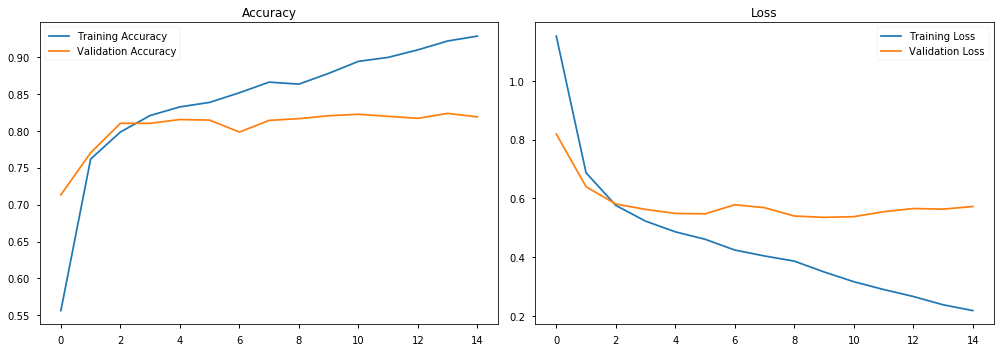

In [31]:
plot_history(history)

In [32]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

80/80 [==============================] - 10s 122ms/step - loss: 0.5636 - accuracy: 0.8235
Test set
  Loss: 0.564
  Accuracy: 0.823


In [34]:
y_predict_proba = model.predict(X_test)

y_predict_class = y_predict_proba.argmax(axis=-1)

y_test_class = np.argmax(y_test,axis=1)

print("Accuracy Score:",accuracy_score(y_test_class,y_predict_class))
classification_report_ = pd.DataFrame(classification_report(y_test_class,y_predict_class,output_dict=True)).T
classification_report_

Accuracy Score: 0.8234597156398105


,precision,recall,f1-score,support
0,0.763723,0.824742,0.793061,388.00000
1,0.838403,0.864706,0.851351,510.00000
2,0.927614,0.862843,0.894057,401.00000
3,0.687332,0.672823,0.680000,379.00000
4,0.857651,0.846604,0.852092,854.00000
accuracy,0.823460,0.823460,0.823460,0.82346
macro avg,0.814945,0.814344,0.814112,2532.00000
weighted avg,0.824967,0.823460,0.823784,2532.00000


In [28]:
model.save('model.hdf5')

# Inference  

In [ ]:
#loading model and Tokenizer

model = load_model('model.hdf5')

index2label = {0:'Worst',1:'Bad',2:'Good',3:'Great'}

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
MAX_SEQUENCE_LENGTH = 200

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
TO_REMOVE_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
NEXTLINE_REPLACE = re.compile('\n')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = NEXTLINE_REPLACE.sub(' ',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = TO_REMOVE_SYMBOLS_RE.sub('', text)  
    text = text.replace('x', '')
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    return text

In [ ]:
def predict(text):
    text = clean_text(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=MAX_SEQUENCE_LENGTH)
    
    y_predict_proba = model.predict(text)
    y_predict_class = y_predict_proba.argmax(axis=-1)
    
    return index2label[y_predict_class[0]],y_predict_class,y_predict_proba

In [ ]:
test_text = """Good movie but not the BEST.

The special effects were OK, some of them looked really fake.

I know it's an action movie and the principal cast are supposed to survive 'till the end of the movie but come on, were they supernatural or what? Only few scratches after all they went through. The bridges and buildings falling down and they passed in the car with no problem. It could be a little more realistic without all the drama: "we survive to everything no matter what".

I suffered a lot watching this movie, I was struggling with myself to not cry, it's very cruel and it's sad imagine all this could really happen, see how everyone dies, everything is destroy and it shows once again how the people in this world thinks: the money and being an "important" person can save your life, the rest of us does not matter.

It's also a wake up call to everyone who lives in this planet. """

predict(test_text)